# Solar System

[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tum-pbs/PhiFlow/blob/develop/docs/Planets_Tutorial.ipynb)


This demo simulates the gravitational pull between multiple massive bodies.
We will use Euler steps in time which do not preserve energy.

[**Φ-Flow**](https://github.com/tum-pbs/PhiFlow)
&nbsp;&nbsp;&nbsp; [**Documentation**](https://tum-pbs.github.io/PhiFlow/)
&nbsp;&nbsp;&nbsp; [**API**](https://tum-pbs.github.io/PhiFlow/phi)
&nbsp;&nbsp;&nbsp; [**Demos**](https://github.com/tum-pbs/PhiFlow/tree/develop/demos)

In [ ]:
# !pip install phiflow

We use the convenience import of Φ<sub>Flow</sub> which imports the core submodules, such as `math` and `vis`.

In [1]:
from phi.flow import *

Let's define the initial positions for our planets.
We stack the position vectors of the planets a long a new [*instance*](https://tum-pbs.github.io/PhiFlow/Math.html#shapes) dimension we call *planets*.
Φ<sub>Flow</sub> also allows us to name the individual elements along that dimension. These names are part of the shape and will be present on all tensors derived from `x` that have this dimension.

In [3]:
x = stack({'Sun': (0, 0), 'Earth': (10, 0), 'Mars': (0, 12)}, instance('planets'))
x = rename_dims(x, 'vector', channel(vector='x,y'))
x

(x=0, y=0); (x=10, y=0); (x=0, y=12) (planetsⁱ=Sun,Earth,Mars, vectorᶜ=x,y)

We can plot these positions by constructing a `PointCloud`, using the `bounds` parameter to specify the axis range. Since the universe we are simulating is infinite, the `bounds` have no physical meaning in this case.

<Figure size 864x360 with 1 Axes>

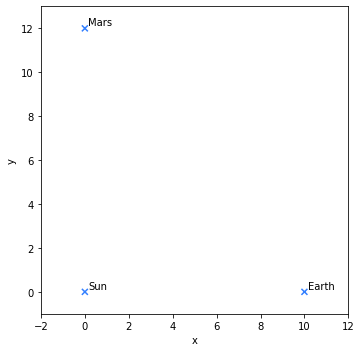

In [4]:
vis.plot(PointCloud(x, bounds=Box(x=(-2, 12), y=(-1, 13))))

Next, let's give the planets initial velocities so that they circle the sun.
For a nice plot, we pass the vector-valued velocities as the `values` of our `PointCloud`.

<Figure size 864x360 with 1 Axes>

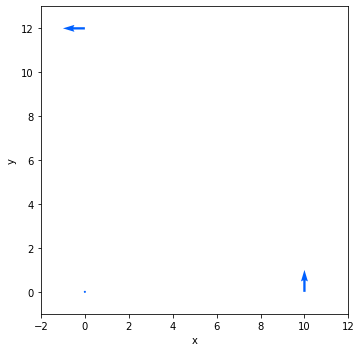

In [5]:
v = math.rotate_vector(x, PI/2)
v = math.divide_no_nan(v, math.vec_length(v))
vis.plot(PointCloud(x, values=v, bounds=Box(x=(-2, 12), y=(-1, 13))))

Next, we define the masses of our planets which will determine the gravitational pull.
These also allow us to make our plot prettier by passing a `Sphere` as the elements of the `PointCloud`.

<Figure size 864x360 with 1 Axes>

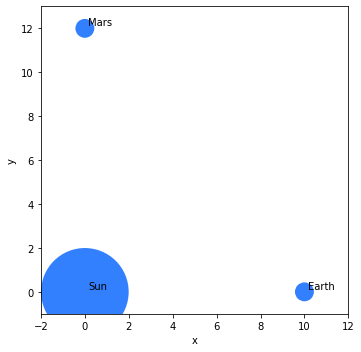

In [6]:
masses = math.stack({'Sun': 1000, 'Earth': 10, 'Mars': 10}, instance('planets'))
vis.plot(PointCloud(Sphere(x, radius=masses**0.333 * .2), bounds=Box(x=(-2, 12), y=(-1, 13))))

To Simulate our system, we define a simple update step and run it repeatedly, collecting all intermediate states in the lists `xs` and `vs`.

For the pair-wise distances between our planets, we use `math.rename_dims` to rename our *planets* dimension to *others*. Our previous tensors are constant along *others*  and the renamed tensor is constant along *planets*.
When combining tensors with different dimensions in an operation, they will be reshaped automatically.

In [7]:
def simulate(x, v, dt=.5):
    dx = x - math.rename_dims(x, 'planets', 'others')
    a = - .01 * math.sum(math.divide_no_nan(math.rename_dims(masses, 'planets', 'others') * dx, math.vec_squared(dx) ** 1.5), 'others')
    return x + v * dt, v + a * dt

xs, vs = [x], [v]
for i in range(100):
    x, v = simulate(x, v)
    xs.append(x)
    vs.append(v)

Finally, let's plot the system trajectory as an animation!
First, we need to define a dimension which will list our animation frames.

In [8]:
xs = math.stack(xs, batch('time'))
vs = math.stack(vs, batch('time'))
xs

(timeᵇ=101, planetsⁱ=Sun,Earth,Mars, vectorᶜ=x,y) -2.464 ± 7.704 (-2e+01...1e+01)

Now we can specify this dimension via the `animate` argument.
Using `vis.overlay` additionally allows us to plot multiple fields in one figure.

In [9]:
vis.plot(vis.overlay(
    PointCloud(Sphere(xs, radius=masses ** 0.333 / 5), bounds=Box(x=(-20, 20), y=(-20, 20))),
    PointCloud(xs, vs * 2, bounds=Box(x=(-20, 20), y=(-20, 20)))), animate='time', frame_time=100)

<Figure size 432x288 with 0 Axes>